# Kaggle - CareerCon 2019
url: https://www.kaggle.com/c/career-con-2019

### ロボットの走行を支援せよ！

## 【主旨】
ロボットの安全な走行のため、現在地の床を予測し、あらゆる地形上で、適正な走行制御を行えるようにしたい。

コンペ開始日：March 13, 2019
コンペ最終日：April 11, 2019
スポンサー：Kaggle
賞品：Kaggle社からの何かイイ品（注；当コンペでは優勝経歴には反映しない）

### 目的変数：
* series_id：計測回数
    * 説明変数と関連
* group_id：学習用の計測集
    * 交差検証用
* 9種類の床
    * コンクリート
    * 舗装コンクリート
    * タイル
    * 柔らかいタイル
    * 堅いタイル
    * 堅いタイル（大）
    * 柔らかいpvc
    * 木製
    * カーペット

### 説明変数：センサーで計測した速度や加速度（合計14カラム）

* row_id：行番号
* measurement_number：計測番号
* series_id：計測回数
    * 目的変数と関連
    * 0, 1, 2
    * 1回の計測に128個の特徴量（3ラベル毎）
    * test: 3816回
    * train: 3810回
* 10種類の特徴量
    * 四元数（3次元空間においての回転）
        1. X方向
        2. Y方向
        3. Z方向
        4. W方向
    * 3次元方向による速度
        5. X方向
        6. Y方向
        7. Z方向
    * 3次元方向による加速度
        8. X方向
        9. Y方向
        10. Z方向            

# 1. データ確認
* 欠損値の確認
* 73個のgroup_id
* series_1の確認


# 2. Feature（特徴量） Engineering
* testとtrainの特徴量はほぼ同一
* されど微差はあるので、標準化する。
* 結果、目的変数ごとに差異を確認。
* 各特徴量に平均値、中央値、最大値、最小値、標準偏差を算出

# 3. Run Model
* Random Forest
* predict_probaで確率を計算
    

In [4]:
import numpy as np 
import pandas as pd 
import os
from time import time
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
# from numba import jit
import itertools
from seaborn import countplot,lineplot, barplot
# from numba import jit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.style as style 
style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
import gc
gc.enable()

print ("Ready !")

Ready !


In [5]:
data = pd.read_csv('CareerCon_2019_X_train.csv')
tr = pd.read_csv('CareerCon_2019_X_train.csv')
# sub = pd.read_csv('../input/career-con-2019/sample_submission.csv')
test = pd.read_csv('CareerCon_2019_X_test.csv')
target = pd.read_csv('Career_Con_2019_y_train.csv')
print ("Data is ready !!")

Data is ready !!


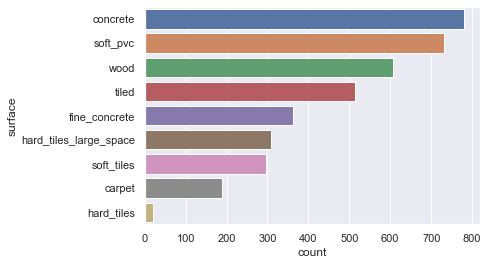

In [7]:
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = target,
              order = target['surface'].value_counts().index)
plt.show()

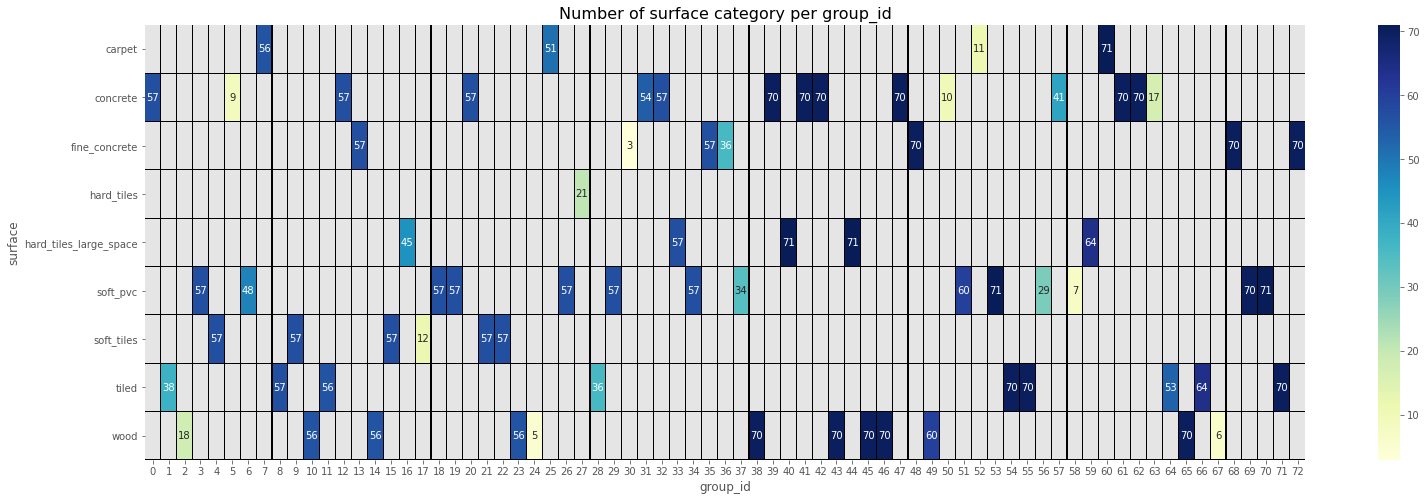

In [6]:
fig, ax = plt.subplots(1,1,figsize=(26,8))
tmp = pd.DataFrame(target.groupby(['group_id', 'surface'])['series_id'].count().reset_index())
m = tmp.pivot(index='surface', columns='group_id', values='series_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of surface category per group_id', size=16)
plt.show()

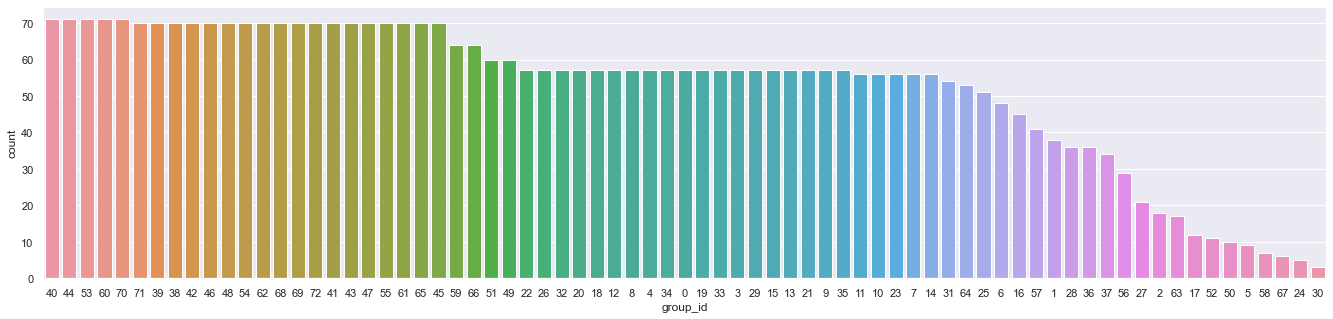

In [8]:
plt.figure(figsize=(23,5)) 
sns.set(style="darkgrid")
countplot(x="group_id", data=target, order = target['group_id'].value_counts().index)
plt.show()

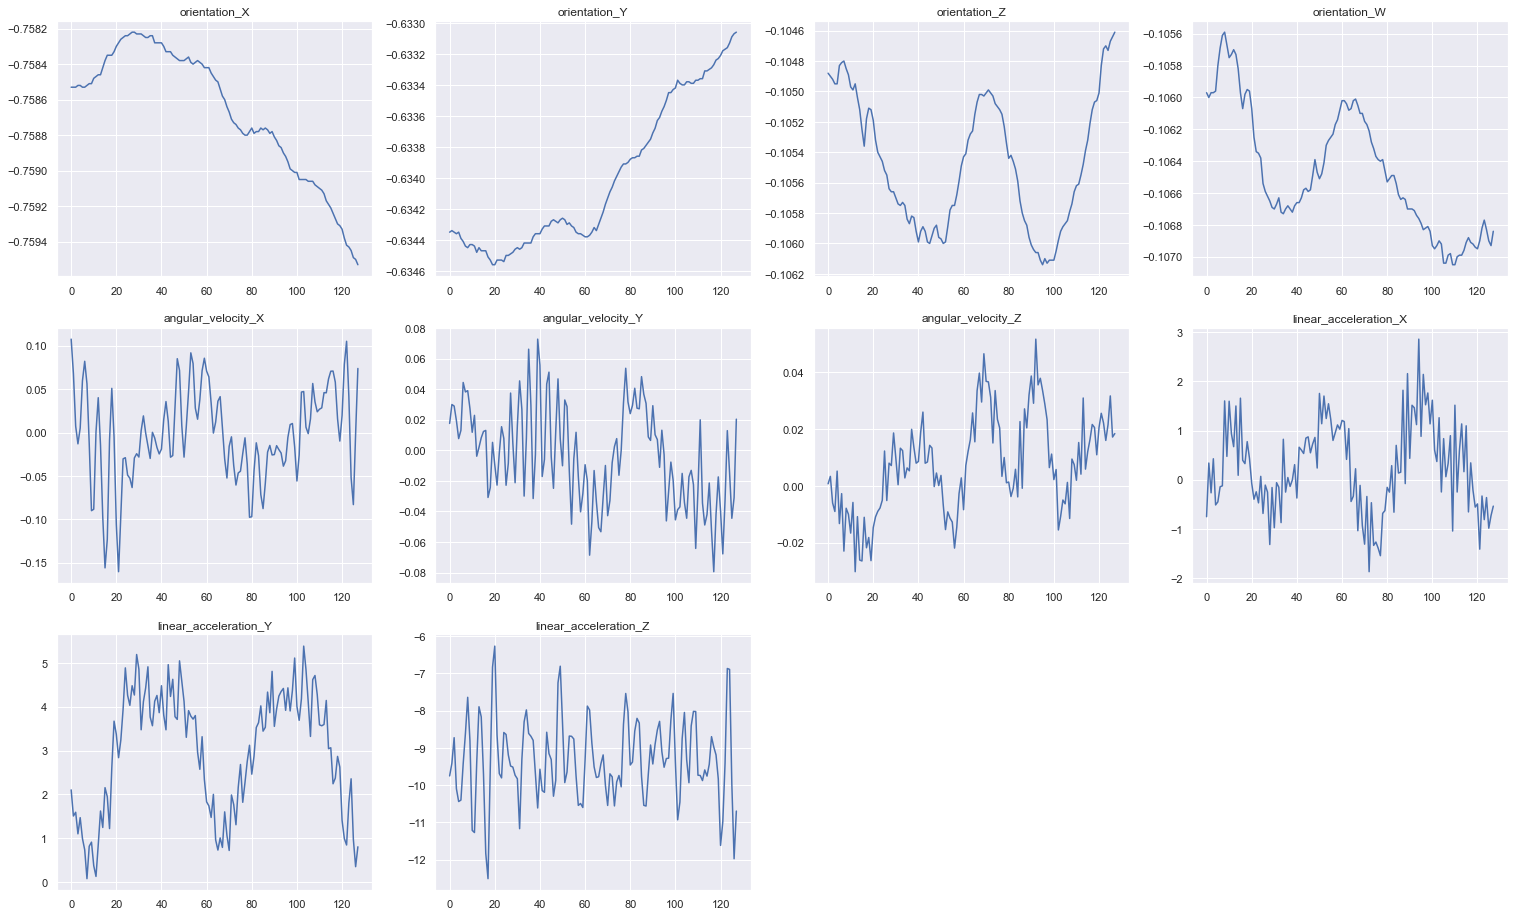

In [10]:
serie1 = tr.head(128)
serie1.head()
plt.figure(figsize=(26, 16))
for i, col in enumerate(serie1.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(serie1[col])
    plt.title(col)

注目すべき傾向
* orientation_X：減少傾向
* orientation_Y：上昇傾向
* linear_acceleration_Y：規則性有り

In [17]:
train_x = pd.read_csv('CareerCon_2019_X_train.csv')
train_y = pd.read_csv('Career_Con_2019_y_train.csv')

In [18]:
import math

def prepare_data(t):
    def f(d):
        d=d.sort_values(by=['measurement_number'])
        return pd.DataFrame({
         'lx':[ d['linear_acceleration_X'].values ],
         'ly':[ d['linear_acceleration_Y'].values ],
         'lz':[ d['linear_acceleration_Z'].values ],
         'ax':[ d['angular_velocity_X'].values ],
         'ay':[ d['angular_velocity_Y'].values ],
         'az':[ d['angular_velocity_Z'].values ],
        })

    t= t.groupby('series_id').apply(f)

    def mfft(x):
        return [ x/math.sqrt(128.0) for x in np.absolute(np.fft.fft(x)) ][1:65]

    t['lx_f']=[ mfft(x) for x in t['lx'].values ]
    t['ly_f']=[ mfft(x) for x in t['ly'].values ]
    t['lz_f']=[ mfft(x) for x in t['lz'].values ]
    t['ax_f']=[ mfft(x) for x in t['ax'].values ]
    t['ay_f']=[ mfft(x) for x in t['ay'].values ]
    t['az_f']=[ mfft(x) for x in t['az'].values ]
    return t

In [19]:
t=prepare_data(train_x)
t=pd.merge(t,train_y[['series_id','surface','group_id']],on='series_id')
t=t.rename(columns={"surface": "y"})

<Figure size 432x288 with 0 Axes>

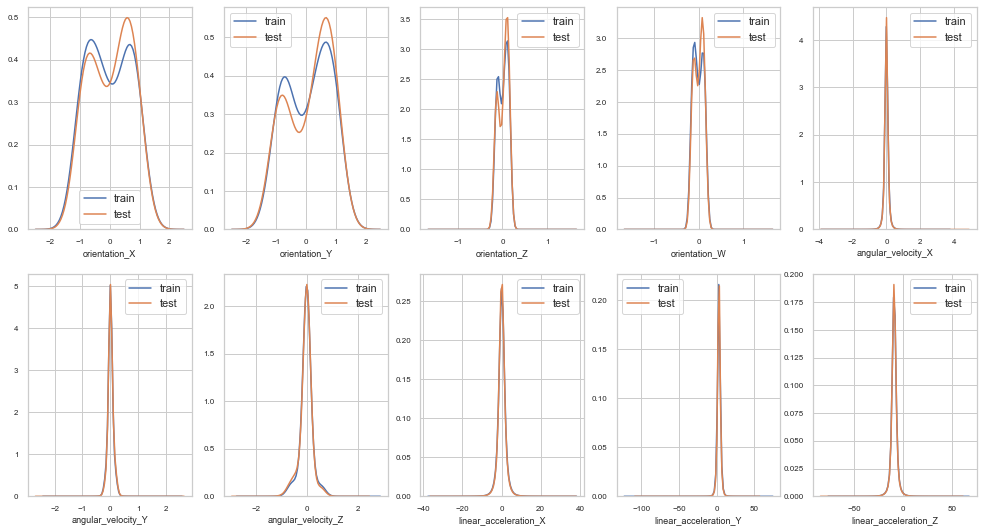

In [20]:
def plot_feature_distribution(df1, df2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

features = data.columns.values[3:]
plot_feature_distribution(data, test, 'train', 'test', features)

<Figure size 432x288 with 0 Axes>

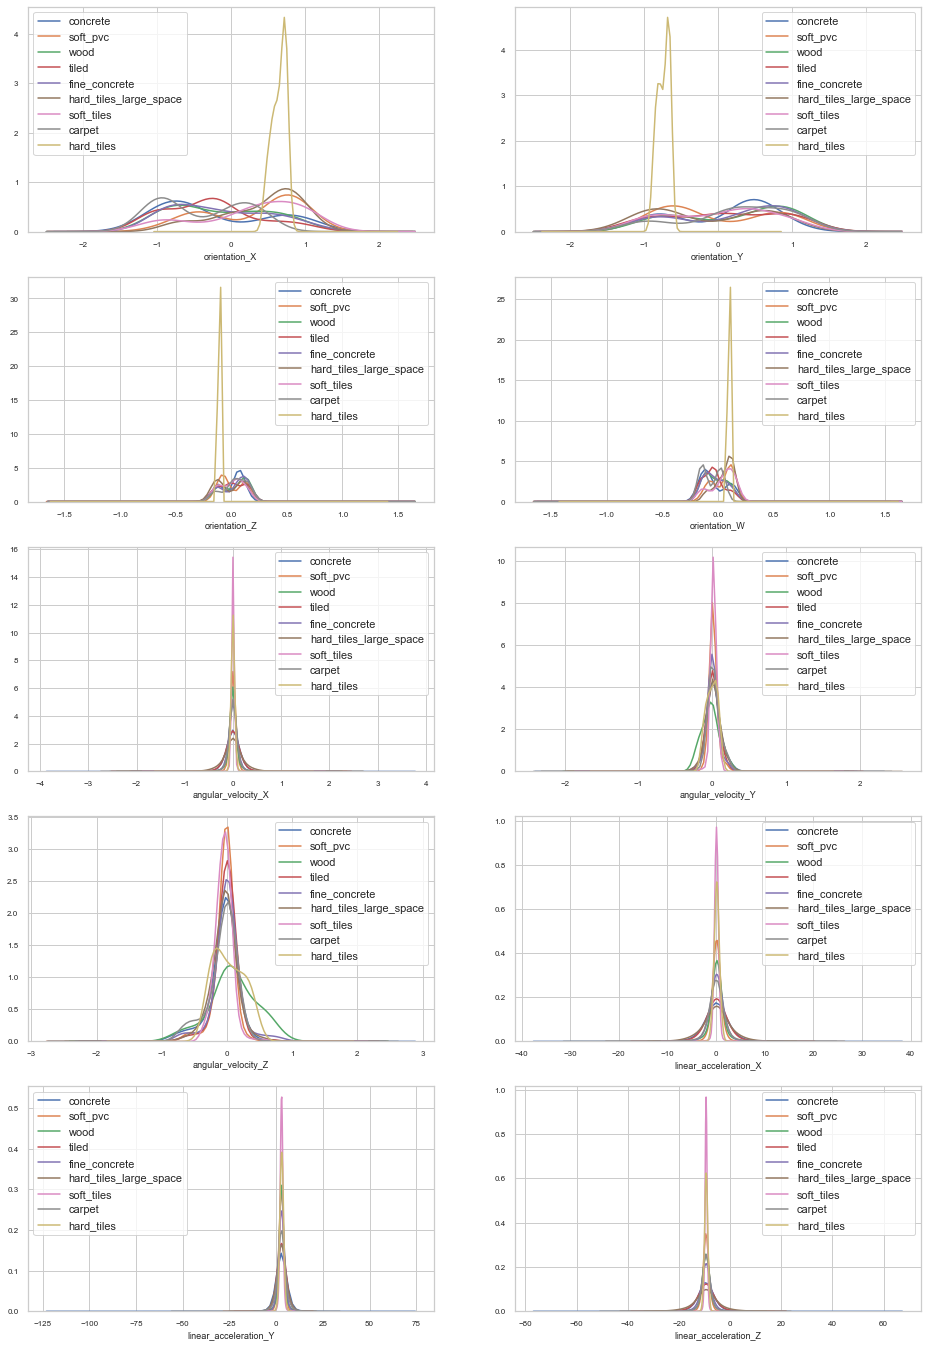

In [21]:
def plot_feature_class_distribution(classes,tt, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

classes = (target['surface'].value_counts()).index
aux = data.merge(target, on='series_id', how='inner')
plot_feature_class_distribution(classes, aux, features)